# Model Testing

### Packages

In [1]:
import pandas as pd
import numpy as np
import pandas as pd

import umap
import umap.plot
from umap import UMAP
import matplotlib.pyplot as plt
import hdbscan

import os
DATA_DIR = "~/Desktop/code/data/"

### Dataset

In [2]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "test_model.csv"), low_memory=False)

filter = train_df["ec"].str.contains("-")
train_df = train_df[~filter]

train_df = train_df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
train_df = train_df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
train_df = train_df.fillna(0.0).reset_index()

train_df.head()

ec,taxon_id,media_id,1.1.1.1,1.1.1.100,1.1.1.102,1.1.1.103,1.1.1.107,1.1.1.108,1.1.1.11,1.1.1.110,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
0,1002526,J22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1004166,1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1004261,J181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1004261,J455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005925,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dimensionality Reduction

#### PCA

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data = train_df.drop(["taxon_id","media_id"], axis=1)

# Preprocessing
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance)

#print("Explained variance by each component:")
#for i, variance in enumerate(explained_variance):
#    print(f"Principal Component {i + 1}: {variance:.4f}")

print(f"\nTotal explained variance by the first n components: {total_explained_variance:.4f}")
data_pca = pd.DataFrame(data_pca)
#data_pca.head()


Total explained variance by the first n components: 0.6863


In [4]:
# Return labels to PCA components
pca_df = data_pca.copy()
labels = train_df[["taxon_id","media_id"]]
pca_df[["taxon_id","media_id"]] = labels
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,taxon_id,media_id
0,-1.809362,-1.383260,-0.583601,-0.063659,-0.163829,-0.433958,0.198945,-0.509242,-0.665073,-0.069089,...,-0.048743,-0.026609,0.035321,-0.077858,0.002962,0.283339,-0.096410,-0.055773,1002526,J22
1,-1.738848,-1.364032,-0.545278,-0.024781,-0.180510,-0.456747,0.105720,-0.557828,-0.784691,-0.058545,...,-0.158826,0.103797,-0.114581,-0.218373,-0.010140,-0.037069,0.146709,0.057246,1004166,1a
2,-1.812860,-1.422730,-0.586148,-0.094710,-0.160502,-0.434751,0.195364,-0.507093,-0.649347,-0.072861,...,-0.029723,-0.034035,0.059770,-0.075700,-0.002337,0.318596,-0.131128,-0.070571,1004261,J181
3,-1.812860,-1.422730,-0.586148,-0.094710,-0.160502,-0.434751,0.195364,-0.507093,-0.649347,-0.072861,...,-0.029723,-0.034035,0.059770,-0.075700,-0.002337,0.318596,-0.131128,-0.070571,1004261,J455
4,-1.808454,-1.383316,-0.583745,-0.063742,-0.163829,-0.433973,0.198920,-0.509096,-0.665120,-0.069058,...,-0.048586,-0.026570,0.035274,-0.077858,0.002889,0.283191,-0.096410,-0.055638,1005925,J118


#### UMAP

In [20]:
from sklearn.model_selection import train_test_split

TARGET_VAR = "taxon_id"
RANDOM_SEED = 666
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

# Split into training/test datasets
X_train, X_test, y_train, y_test = train_test_split(
    pca_df.drop(["taxon_id", "media_id"], axis=1),
    pca_df[TARGET_VAR],
    test_size=0.2,
    random_state=RANDOM_SEED
)

# Initiate the UMAP reducer
reducer = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=2,
    n_epochs=500, #200, 500, 5000
    random_state=UMAP_SEED,
    n_jobs=1,
    n_neighbors=20, #20
    min_dist=0.5 #0.8 ~effectively removes disconnect...TODO: attempt to optimize n_neighbors and min_dist
)

# Apply UMAP to our model
umap_model = reducer.fit(X_train) # Fit the model
umap_embeddings = reducer.transform(X_train) # Transform the data to obtain the embeddings

# Get disconnected vertices
disconnected_points = umap.utils.disconnected_vertices(umap_model)

# Create a DataFrame from the embeddings
reduced = pd.DataFrame(umap_embeddings, columns=[f"Component {i+1}" for i in range(umap_embeddings.shape[1])])

#reduced.head()

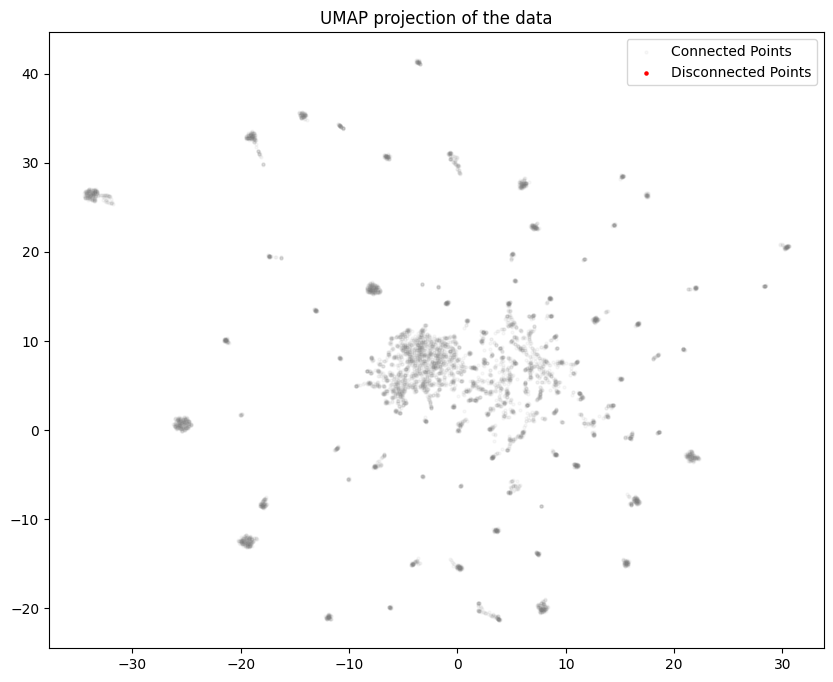

In [22]:
# Plotting the embeddings with different colors for disconnected points
plt.figure(figsize=(10, 8))

# Plot the connected points
connected_points = ~disconnected_points
plt.scatter(
    umap_embeddings[connected_points, 0],
    umap_embeddings[connected_points, 1],
    s=5,
    c='grey',  # Color for connected points
    alpha=0.05,
    label='Connected Points'
)

# Plot the disconnected points
plt.scatter(
    umap_embeddings[disconnected_points, 0],
    umap_embeddings[disconnected_points, 1],
    s=5,
    c='red',  # Color for disconnected points
    label='Disconnected Points'
)

plt.title('UMAP projection of the data')
plt.legend()
plt.show()

### Cluster

In [23]:
# hdbscan clustering
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10, gen_min_span_tree=True, prediction_data=True) # cluster_selection_method="leaf", 
clusters = clusterer.fit_predict(reduced)

# Add labels
reduced['Cluster'] = clusters
reduced[["taxon_id", "media_id"]] = train_df.loc[X_train.index, ["taxon_id", "media_id"]].values
print(clusterer.labels_.max(), "clusters")

reduced.head()

188 clusters


,Component 1,Component 2,Cluster,taxon_id,media_id
0,0.505041,6.694573,124,1128618,J75
1,-25.267872,0.134438,7,433296,J363
2,-2.471298,2.729445,107,1818723,J43
3,-25.932198,1.188559,7,"[{'NCBI tax id': 797299, 'Matching level': 'st...",J168
4,-19.553444,-13.066827,12,173363,J22


In [24]:
import plotly.express as px
import plotly.graph_objects as go

# Optional remove outliers
filtered = reduced[reduced['Cluster'] >= 0]

fig = px.scatter(
    data_frame = filtered,
    x = "Component 1",
    y = "Component 2",
    color = "Cluster",
    hover_data = ["taxon_id", "media_id"],
    opacity = 0.05,
    template="plotly_white"
) 

fig.show()

### Predict

In [25]:
# Subset test_points based on samples of "unknown" media_id
test_points = reduced.copy()
MAGs = test_points["media_id"].str.contains("unknown")
test_points = test_points[MAGs]

# Convert to numpy array for hdbscan
test_points = test_points[["Component 1", "Component 2"]].to_numpy()

# Predict cluster based on model
test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)

#test_points
#test_labels

In [26]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(
    data_frame = filtered,
    x = "Component 1",
    y = "Component 2",
    color = "Cluster",
    hover_data = ["taxon_id", "media_id"],
    opacity = 0.01,
    template="plotly_white"
) 

# Add the new test points as a scatter trace
fig.add_trace(
    go.Scatter(
        x=test_points[:, 0],  # x coordinates
        y=test_points[:, 1],  # y coordinates
        mode='markers',
        marker=dict(
            color='black',  # Color for the new markers
            size=8,  # Marker size
            opacity=0.8  # Marker opacity
        ),
        text=test_labels,  # Hover text for new points
        name='MAGs',  # Legend label
        showlegend=True
    )
)


# To-do: 

Automate way of finding the nearest neighbors for test_points (and associated taxon/media info)

Automate optimal number of hdbscan clusters? Built-in, or will silhouette work here too?

Optimize UMAP function parameters

Add more test points (EC-annotated MAGs)